In [5]:
import pathlib, pickle


class Game: 
    
    def __init__(self, strats = None, pi = None, S = 1, P = 2, R = 3, T = 4, A = None):
        
        assert S < P < R < T
        assert 2 * R > T + S
        self.S = S 
        self.P = P
        self.R = R 
        self.T = T
        
        self.strats = strats
        self.pi = pi
        self.A = A
        
        self.soln = None
        self.Time_plot = None
        self.Flow_plot = None
     
    #calculate payoffs sx, sy when player X with strat1 plays player Y with strat2
    def calculate_payoff(self, strat1, strat2): 
        alpha, beta, a, b = strat1[0], strat1[1], strat2[0], strat2[1]
        D = beta * b - alpha * a #Determinant
        sx = 1/D * (a - beta) 
        sy = 1/D * (alpha - b)
        return (sx, sy)

    def compute_A(self): 
        A = matrix(RR, 3, 3) #initialize an identity matrix
        for i in range(len(self.strats)): 
            for j in range(i, len(self.strats)): 
                sx, sy = self.calculate_payoff(self.strats[i], self.strats[j])
                # print(i, j, sx, sy)
                A[i, j] = sx
                A[j, i] = sy
        self.A = A
        return A
    
    def compute_game(self):
       
        if not self.A: #case where the game matrix has not been computed yet
            self.compute_A()
        
        t = var('t') 
        pi_var = vector(var("pi_0, pi_1, pi_2"))

        A_i_pi = list()
        for i in range(3): 
            A_i_pi.append(pi_var.dot_product(self.A[i]))

        A_pi_pi = pi_var.dot_product(vector(A_i_pi))

        de_system = list()

        for i in range(3):
            de_system.append( pi_var[i] * (A_i_pi[i] - A_pi_pi) )


        self.soln = desolve_system_rk4(de_system, pi_var, ivar = t, ics = [0] + pi, step = .2, end_points=100)
        #2D list with each 1D list of form [t, de1, de2, de3, ... deN]

        return self.soln

    def generate_graphs(self): 

        soln = self.compute_game()

        strat0 = [[i,j] for i,j,k,l in soln]
        strat1 = [[i,k] for i,j,k,l in soln]
        strat2 = [[i,l] for i,j,k,l in soln]
        flow = [[j,k] for i,j,k,l in soln]

        #create time plot
        legend = lambda num, strat: "strat " + str(num) + ": " + str(strat)
        LP1 = list_plot(strat0, color = "blue", legend_label= legend(0, strats[0]), title = "pop. initial cond: " + str(pi))
        LP2 = list_plot(strat1, color = "purple", legend_label= legend(1, strats[1]))
        LP3 = list_plot(strat2, color = "green", legend_label= legend(2, strats[2]))
        Time_plot = LP1 + LP2 + LP3
        Time_plot.axes_labels(["$t$", "population ratio"])
        Time_plot.show(title = "pop. initial cond: " + str(pi))

        #create flow plot
        Flow = list_plot(flow, color="red") + points([flow[0]], color="blue", size = "40", legend_label="start", title = r"initial cond: [$\pi_0, \pi_1, \pi_2$] = " + str(pi)) + points([flow[-1]], color="green", size = "40", legend_label="end")
        Flow_plot = Flow + plot(1 - x, 0, 1, color = "grey")
        Flow_plot.axes_labels([r"$\pi_0$", r"$\pi_1$"])
        # Flow_plot.show(title = r"initial cond: [$\pi_0, \pi_1, \pi_2$] = " + str(pi))

        self.Time_plot = Time_plot
        self.Flow_plot = Flow_plot
        
        return (Time_plot, Flow_plot)

    def save(self):
        #create folder
        # cl = "IC: " + str(pi) + ";strats: " + str(strats)
        cl = hash(tuple(self.pi + self.strats))
        folder_name = f"example_{cl}"
        folder = pathlib.Path(folder_name)
        folder = folder.resolve()
        folder.mkdir()

        #save parameters as txt file
        with open(str(folder) + "/parameters.txt", 'w') as f: 
            f.write(f'S: {self.S}, P: {self.P}, R: {self.R}, T:{self.T}\n')
            f.write("pi aka initial conditions of population: " + str(self.pi) + "\n") 
            f.write("strategies in format (alpha, beta): " + str(self.strats) + "\n")

        #pickle pi and strats 
        assert self.pi #make sure it is not a None object
        with open(str(folder) + "/pi_pickle", 'wb') as f: 
            pickle.dump(self.pi, f)

        assert self.strats #make sure it is not None object
        with open(str(folder) + "/strats_pickle", 'wb') as f:
            pickle.dump(self.strats, f)

        if not (self.Time_plot and self.Flow_plot): 
            self.generate_graphs()

        self.Time_plot.save(str(folder) + "/time.png")
        self.Flow_plot.save(str(folder) + "/flow.png") 
        
    
    def load(self): 
        return 
        
        

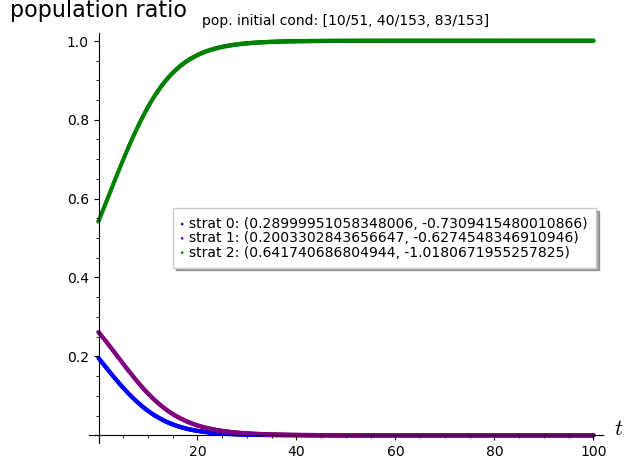

In [6]:
S, P, R, T = 1, 2, 3, 4

assert S < P < R < T
assert 2 * R > T + S

def create_strat(alpha, Z):
    assert P <= Z <= R
    assert alpha >= -1
    return (alpha, -1 * (alpha + 1/Z))
    
    
ITER = 1
NUM_IC = 3

#initiate strats
parameters = [ (uniform(-1, 1), uniform(P, R)) for i in range(3)]
strats = [ create_strat(*parm) for parm in parameters ]

#initiate initial conditions
populations = [ZZ.random_element(1, 100) for i in range(3)] 
total = sum(populations)
pi = [pop/total for pop in populations] #initial conditions

for it in range(ITER):
    
    parameters = [ (uniform(-1, 1), uniform(P, R)) for i in range(3)]
    strats = [ create_strat(*parm) for parm in parameters ]

    for i in range(NUM_IC): 
        populations = [ZZ.random_element(1, 100) for i in range(3)] 
        total = sum(populations)
        pi = [pop/total for pop in populations] #initial conditions
        
        G = Game(strats, pi) 
        G.generate_graphs() 
        G.save()
    
    